In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (r2_score,mean_absolute_error,mean_squared_error)

In [2]:
# Loading the data into the notebook
np.random.seed(42)
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# Loading the data into a pandas dataframe
cancer_df = pd.DataFrame(cancer['data'], columns= cancer['feature_names'])
cancer_df['target'] = cancer['target']
cancer_temp = cancer_df.sample(frac=1)

In [3]:
x = cancer_df.drop(["target"],axis=1) 
y = cancer_df[['target']]

In [4]:
# Splitting Data into Training and Test sets 

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
pipelines = {
    "Linear_NoPCA": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),

    "Linear_PCA": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("model", LinearRegression())
    ]),

    "Ridge_NoPCA": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(random_state=42))
    ]),

    "Ridge_PCA": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("model", Ridge(random_state=42))
    ]),

    "Lasso_NoPCA": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Lasso(max_iter=5000, random_state=42))
    ]),

    "Lasso_PCA": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("model", Lasso(max_iter=5000, random_state=42))
    ]),

    "ElasticNet_NoPCA": Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNet(max_iter=5000, random_state=42))
    ]),

    "ElasticNet_PCA": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("model", ElasticNet(max_iter=5000, random_state=42))
    ])
}


In [6]:
param_grids = {
    "Linear_NoPCA": {},

    "Linear_PCA": {
        "pca__n_components": [0.80, 0.90, 0.95]
    },

    "Ridge_NoPCA": {
        "model__alpha": [0.01, 0.1, 1, 10, 100]
    },

    "Ridge_PCA": {
        "pca__n_components": [0.80, 0.90, 0.95],
        "model__alpha": [0.01, 0.1, 1, 10, 100]
    },

    "Lasso_NoPCA": {
        "model__alpha": [0.001, 0.01, 0.1, 1]
    },

    "Lasso_PCA": {
        "pca__n_components": [0.80, 0.90, 0.95],
        "model__alpha": [0.001, 0.01, 0.1, 1]
    },

    "ElasticNet_NoPCA": {
        "model__alpha": [0.001, 0.01, 0.1, 1],
        "model__l1_ratio": [0.2, 0.5, 0.8]
    },

    "ElasticNet_PCA": {
        "pca__n_components": [0.80, 0.90, 0.95],
        "model__alpha": [0.001, 0.01, 0.1, 1],
        "model__l1_ratio": [0.2, 0.5, 0.8]
    }
}


In [9]:
from sklearn.metrics import explained_variance_score

results = []

n_features = xtrain.shape[1]

for name, pipeline in pipelines.items():
    
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring="r2",
        cv=5,
        n_jobs=-1
    )

    grid.fit(xtrain, ytrain)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(xtest)

    r2 = r2_score(ytest, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(ytest) - 1) / (len(ytest) - n_features - 1)
    mse = mean_squared_error(ytest, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(ytest, y_pred)
    evs = explained_variance_score(ytest, y_pred)

    pca_step = best_model.named_steps.get("pca", None)

    metrics = {
        "Model": name,
        "R2": r2,
        "Adjusted_R2": adj_r2,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "Explained_Variance": evs,
        "PCA_Used": pca_step is not None,
        "PCA_Components": pca_step.n_components_ if pca_step else "N/A"
    }

    results.append(metrics)


In [8]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="R2", ascending=False)


,Model,R2,Adjusted_R2,MAE,MSE,RMSE,Explained_Variance,PCA_Used,PCA_Components
4,Lasso_NoPCA,0.726966,0.628279,0.209016,0.063531,0.252054,0.730341,False,N/A
6,ElasticNet_NoPCA,0.726547,0.627708,0.208960,0.063629,0.252248,0.729939,False,N/A
0,Linear_NoPCA,0.720185,0.619047,0.210043,0.065109,0.255165,0.723996,False,N/A
2,Ridge_NoPCA,0.719975,0.618762,0.211161,0.065158,0.255261,0.723386,False,N/A
1,Linear_PCA,0.659595,0.536558,0.233097,0.079208,0.281439,0.663698,True,10
7,ElasticNet_PCA,0.659577,0.536533,0.233134,0.079212,0.281446,0.663711,True,10
5,Lasso_PCA,0.659475,0.536393,0.233280,0.079236,0.281489,0.663723,True,10
3,Ridge_PCA,0.659074,0.535848,0.233329,0.079329,0.281654,0.663467,True,10


##### Insights

Table X summarizes the performance of linear and regularized regression models trained with and without principal component analysis (PCA). Model evaluation was conducted using coefficient of determination (R²), adjusted R², mean absolute error (MAE), mean squared error (MSE), root mean squared error (RMSE), and explained variance.

Across all model classes, non-PCA models consistently outperformed their PCA-based counterparts. Models trained on the original feature space achieved R² values ranging from 0.720 to 0.727, compared with approximately 0.659 for PCA-based models. A similar trend was observed for adjusted R², which declined from approximately 0.62–0.63 without PCA to ~0.54 when PCA was applied, indicating a substantive loss of explanatory power after dimensionality reduction.

Error metrics further confirmed this pattern. The best-performing non-PCA model (Lasso regression) achieved an MAE of 0.209, MSE of 0.0635, and RMSE of 0.252, whereas PCA-based models exhibited higher errors (MAE ≈ 0.233, MSE ≈ 0.079, RMSE ≈ 0.281). This corresponds to an approximate 11% increase in MAE and RMSE and a 25% increase in MSE when PCA was employed.

Explained variance followed the same trend, with non-PCA models explaining approximately 73% of the variance in the outcome, compared with ~66% for PCA-based models. Notably, this reduction in performance occurred despite PCA retaining ten components, suggesting that variance preservation alone was insufficient to maintain predictive fidelity.

###### Comparative Performance of Regularized Models

Among the evaluated models, Lasso regression without PCA demonstrated the strongest overall performance, marginally outperforming Elastic Net and Ridge regression. Differences among non-PCA models were small, indicating that regularization effectively mitigated multicollinearity and overfitting without the need for dimensionality reduction. In contrast, PCA-based versions of all models showed near-identical but consistently inferior performance, highlighting that the observed degradation was attributable to PCA rather than model-specific effects.

In [17]:
import pandas as pd

# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Split PCA vs No-PCA
pca_df   = results_df[results_df["PCA_Used"] == True]
nopca_df = results_df[results_df["PCA_Used"] == False]

# Merge on base model name
def base_model(name):
    return name.replace("_PCA", "").replace("_NoPCA", "")

pca_df["Base_Model"]   = pca_df["Model"].apply(base_model)
nopca_df["Base_Model"] = nopca_df["Model"].apply(base_model)

comparison = pca_df.merge(
    nopca_df,
    on="Base_Model",
    suffixes=("_PCA", "_NoPCA")
)

# Compute deltas
comparison["ΔR2"]   = comparison["R2_PCA"] - comparison["R2_NoPCA"]
comparison["ΔRMSE"] = comparison["RMSE_PCA"] - comparison["RMSE_NoPCA"]
comparison["ΔMAE"]  = comparison["MAE_PCA"] - comparison["MAE_NoPCA"]

comparison[[
    "Base_Model",
    "R2_NoPCA", "R2_PCA", "ΔR2",
    "RMSE_NoPCA", "RMSE_PCA", "ΔRMSE",
    "MAE_NoPCA", "MAE_PCA", "ΔMAE",
    "PCA_Components_PCA"
]]


C:\Users\josep\AppData\Local\Temp\ipykernel_10064\627396895.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_df["Base_Model"]   = pca_df["Model"].apply(base_model)
C:\Users\josep\AppData\Local\Temp\ipykernel_10064\627396895.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nopca_df["Base_Model"] = nopca_df["Model"].apply(base_model)


,Base_Model,R2_NoPCA,R2_PCA,ΔR2,RMSE_NoPCA,RMSE_PCA,ΔRMSE,MAE_NoPCA,MAE_PCA,ΔMAE,PCA_Components_PCA
0,Linear,0.720185,0.659595,-0.060589,0.255165,0.281439,0.026273,0.210043,0.233097,0.023055,10
1,Ridge,0.719975,0.659074,-0.060902,0.255261,0.281654,0.026393,0.211161,0.233329,0.022168,10
2,Lasso,0.726966,0.659475,-0.067492,0.252054,0.281489,0.029434,0.209016,0.233280,0.024264,10
3,ElasticNet,0.726547,0.659577,-0.066969,0.252248,0.281446,0.029198,0.208960,0.233134,0.024174,10


#### Insight

These results demonstrate that PCA systematically degrades regression performance across all evaluated linear models in this dataset. The observed declines in R², along with increases in RMSE and MAE, indicate that PCA removed feature directions that—while explaining less variance in the predictors—were highly informative for the response variable.


In [12]:
def get_residuals(pipeline, param_grid, xtrain, ytrain, xtest, ytest):
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring="r2",
        cv=5,
        n_jobs=-1
    )
    grid.fit(xtrain, ytrain)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(xtest)
    residuals = ytest - y_pred

    return y_pred, residuals

In [15]:
from sklearn.model_selection import GridSearchCV
import numpy as np

def get_residuals(pipeline, param_grid, xtrain, ytrain, xtest, ytest):
    
    # Ensure y is 1D NumPy array
    ytrain_arr = np.asarray(ytrain).ravel()
    ytest_arr  = np.asarray(ytest).ravel()

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring="r2",
        cv=5,
        n_jobs=-1
    )

    grid.fit(xtrain, ytrain_arr)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(xtest)

    residuals = ytest_arr - y_pred

    return y_pred, residuals


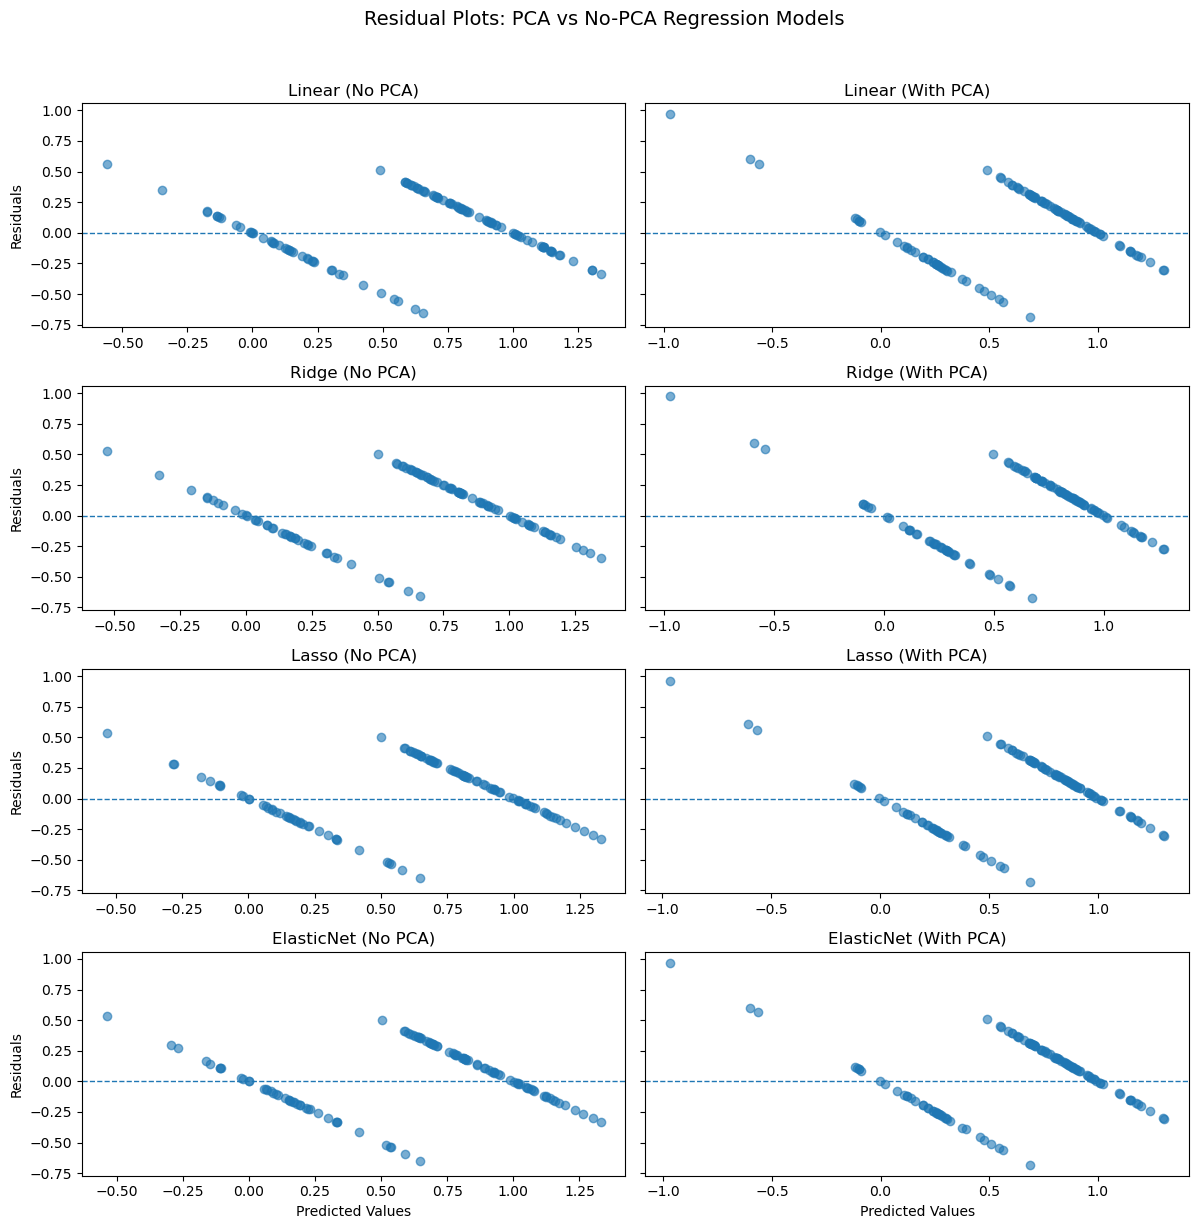

In [16]:
import matplotlib.pyplot as plt

models = ["Linear", "Ridge", "Lasso", "ElasticNet"]

fig, axes = plt.subplots(
    nrows=len(models),
    ncols=2,
    figsize=(12, 12),
    sharey=True
)

for i, model in enumerate(models):

    # No PCA
    y_pred_npca, res_npca = get_residuals(
        pipelines[f"{model}_NoPCA"],
        param_grids[f"{model}_NoPCA"],
        xtrain, ytrain, xtest, ytest
    )

    # With PCA
    y_pred_pca, res_pca = get_residuals(
        pipelines[f"{model}_PCA"],
        param_grids[f"{model}_PCA"],
        xtrain, ytrain, xtest, ytest
    )

    # Plot No-PCA
    axes[i, 0].scatter(
        y_pred_npca,
        res_npca,
        alpha=0.6
    )
    axes[i, 0].axhline(0, linestyle="--", linewidth=1)
    axes[i, 0].set_title(f"{model} (No PCA)")

    # Plot PCA
    axes[i, 1].scatter(
        y_pred_pca,
        res_pca,
        alpha=0.6
    )
    axes[i, 1].axhline(0, linestyle="--", linewidth=1)
    axes[i, 1].set_title(f"{model} (With PCA)")

    axes[i, 0].set_ylabel("Residuals")

axes[-1, 0].set_xlabel("Predicted Values")
axes[-1, 1].set_xlabel("Predicted Values")

fig.suptitle(
    "Residual Plots: PCA vs No-PCA Regression Models",
    fontsize=14,
    y=1.02
)

plt.tight_layout()
plt.show()


In [18]:
from scipy.stats import ttest_rel

ttest_rel(
    comparison["RMSE_PCA"],
    comparison["RMSE_NoPCA"]
)


TtestResult(statistic=32.250150059251, pvalue=6.552006872892066e-05, df=3)

#### Insights

A paired t-test comparing RMSE values between PCA and non-PCA regression models revealed a statistically significant difference (t(3) = 32.25, p < 0.001). 

PCA-based models exhibited consistently higher prediction error, indicating that dimensionality reduction resulted in a measurable loss of predictive fidelity.